<H2>Streaming viz made easy with hvPlot + Streamz</H2>
<H3>James A. Bednar</H3>

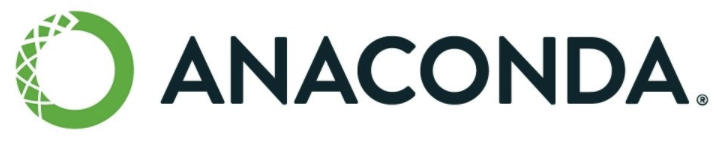

## Streaming viz made easy with hvPlot + Streamz

- Interested in visualizing streaming (live) data?
- Not planning to become a GUI programmer?
- Try streamz + hvPlot!
- Streaming viz, using APIs you already know
<br>

- To follow along: 
   * Download [bit.ly/streaming_hvplot](http://bit.ly/streaming_hvplot)
   * Unzip and do `anaconda-project run`

# What is [Streamz](https://streamz.readthedocs.io)?

- A Python framework for working with streaming data
- Powerful enough to handle complex branching pipelines
- But easy to use for simple pipelines
- Provides streaming Pandas-based DataFrames
- Works well with Jupyter, [Tornado](https://streamz.readthedocs.io/en/latest/async.html#asynchronous-computation), - [Kafka](https://streamz.readthedocs.io/en/latest/api.html#streamz.from_kafka), [CUDA](https://streamz.readthedocs.io/en/latest/api.html?highlight=cuda), [Dask](https://streamz.readthedocs.io/en/latest/dask.html), [Influx](https://www.influxdata.com/blog/streaming-time-series-with-jupyter-and-influxdb), ...


In [2]:
!pip install streamz

# Simple streamz example

A Pandas-based DataFrame of random values:

In [4]:
from streamz.dataframe import Random
df = Random(interval='200ms', freq='50ms')
df.tail()

# It's Pandas, but streaming:

In [5]:
df.x.sum()

In [6]:
sdf = (df.x - 0.5).cumsum()
sdf.tail()

In [7]:
df.stop()

# What is hvPlot?

hvPlot uses the same Pandas .plot() API you already know:

In [8]:
import pandas as pd
import numpy as np
df2 = pd.DataFrame(np.random.randn(5, 3), columns=list('ABC'))
df2.plot();

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

But now provides interactive Bokeh-based plots: 

In [ ]:
import hvplot.pandas

df2.hvplot()

# So, what's Streamz+hvPlot?

Exactly what you'd think:

In [ ]:
import hvplot.streamz
df3 = Random(interval='200ms', freq='50ms')
sdf = (df3.x - 0.5).cumsum()
sdf.hvplot(backlog=100)

Well, not _exactly_; hvPlot objects also support bonus functionality from [HoloViews](https://holoviews.org) like overlays as `*` and layouts as `+`:

In [ ]:
sdf.hvplot(backlog=100) * sdf.rolling('500ms').mean().hvplot(backlog=100) \
 + sdf.hvplot.box(width=100)

In [ ]:
df3.stop()

See [hvPlot.holoviz.org](https://hvplot.holoviz.org) for lots and lots of examples that can be made streaming; pretty much anything hvPlot supports.

# So how can I stream my own data?

- Good question! Surely you don't want just random values
- Streamz offers lots of low-level functionality for building streaming pipelines
- Plus some interfaces to other streaming sources like Kafka

But if you don't need any of that complexity, you can simply write a Python function that returns a Pandas dataframe with some results, and streamz can then periodically run that function to get the latest data. E.g. here are some simple functions that query the current CPU and memory usage of your system:

In [ ]:
import pandas as pd, time, psutil

def mem_data(**kwargs):
    vmem = psutil.virtual_memory()
    return pd.DataFrame(dict(used=100*vmem.used/vmem.total,
                             free=100*vmem.free/vmem.total),
                        index=[pd.Timestamp.now()])

def cpu_data(**kwargs):
    cpu_percent = psutil.cpu_percent(percpu=True)
    df = pd.DataFrame(list(enumerate(cpu_percent)),
                      columns=['CPU', 'Utilization'])
    df['time'] = pd.Timestamp.now()
    return df

Each of these functions accepts some arguments (and ignores them for now), returning a Pandas dataframe with some data. Using PeriodicDataFrame from streamz 0.6 or later, these functions are all you need to get a Pandas-based streaming dataframe:

In [ ]:
from streamz.dataframe import PeriodicDataFrame

mem_df = PeriodicDataFrame(mem_data, interval='300ms')
cpu_df = PeriodicDataFrame(cpu_data, interval='300ms')

cpu_df

The above dataframes should periodically update every 0.3 seconds with the results of calling mem_data and cpu_data, always reporting the most current data.

We can now use mem_df and cpu_df just about anywhere we'd use a regular Pandas DataFrame. In particular, we can very easily set up a little graphical app with hvPlot to monitor the most recent 200 measurements of CPU and memory usage:

In [ ]:
import hvplot.streamz, holoviews as hv

mem = mem_df.hvplot.line(title="Memory Usage", backlog=200)
cpu = cpu_df.hvplot.box(by="CPU", title="CPU Usage", backlog=200)
cpu.opts(box_fill_color=hv.dim('CPU').str(), cmap='Category20')

(cpu + mem).cols(1)

The above visualization should run fine in Jupyter, but it's just as easy to launch a separate server so that it can run as a standalone web app. Just include a cell like the following, with a [Panel](https://panel.holoviz.org) app marked `.servable()`, then go to the command line on your system in a suitable conda environment and run `panel serve --show streaming_hvplot.ipynb`. (Or if you have downloaded this notebook as an anaconda-project, run `anaconda-project run app`.)

Either way, the address of your server should be displayed, and you can then open it in a web browser.

In [ ]:
import panel as pn
pn.Column("# Streamz/Bokeh/hvPlot System Monitor", cpu, mem).servable();

It's as simple as that! You provide the call to fetch new data, and everything else works like normal Pandas dataframes, including plotting, but now dynamically updating. Enjoy!

# Conclusion

- For streaming viz, it's easy to make a custom streaming dataframe with [streamz](https://streamz.readthedocs.io)
- Then you can have streaming plots with [hvplot.streamz](https://hvplot.holoviz.org)
- And deploy as apps with [Panel](https://panel.holoviz.org)
- See [streamz_sysmon.ipynb](streamz_sysmon.ipynb) for a self-contained example
- Want to dive deeper? See [HoloViews](https://holoviews.org/user_guide/Streaming_Data.html), [Panel](https://panel.holoviz.org/reference/panes/Streamz.html), and [custreamz](https://medium.com/rapids-ai/gpu-accelerated-stream-processing-with-rapids-f2b725696a61)